# First Test

Very simple 1D model to try the integration of empymod into SimPEG.

**Limiations at this point:**

- Inversion only for infinitesimal small x-directed electric source and receiver (ab == 11)
- Frequency domain, using lagged convolution type digital linear filters
- Inversion only for resistivity ($\rho_h$), hence fixed values for anisotropy ($\lambda$), electric permeabilities ($\epsilon_h$, $\epsilon_v$) and magnetic permeabilities ($\mu_h$, $\mu_v$)
- Fixed depth structure (ont inverting for layer thicknesses)
- No `numexpr`, no looping
- *Only one frequency and one offset? Or several frequencies, one offset? Or several offsets, one frequency?*
- Start with numerical derivatives. Hunziker et al. (2016) published the code iEMmod which contains the analytical derivatives for the case ef electric source and receivers, so it should not be too difficult to include at a later point the analytical derivatives into empymod. (I might start that in parallel.)


**Other considerations**

- SimPEG supports, I think, Python 2.7 and 3+, however, empymod only supports Python 3.4, 3.5, 3.6.

The example uses 6 offsets (hence 6 complex values), and the inversion model has 21 free layers (including the lower halfspace), so 21 parameters (as we only invert for resistivity at this time).

In [1]:
import numpy as np
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0

import SimPEG
import empymod

## 1. Forward model, create data

Lets define a simple forward model to generate some data, the canonical CSEM model (e.g., Constable and Weiss, 2006). We define only the minimum required input, and leave everything else at its default value.

### 1.1 Define model and create data

In [2]:
depth = [ 0, 1000, 2000, 2100] # Layer boundaries
res =   [2e14, .3, 1, 100, 1]  # Air, sea, overburden, target, underburden
freq = 1                       # 1 Hz
src = [0, 0, 900]              # Src coordinates
x = np.arange(2, 8)*1000       # Offsets
rec = [x, x*0, 1000]           # Rec coordinates

data = empymod.dipole(src, rec, depth, res, freq)

# Lets also calculate a denser model and the background, just to compare it
xf = np.arange(1, 80)*100       # Offsets
rec2 = [xf, xf*0, rec[2]]
full = empymod.dipole(src, rec2, depth, res, freq)
bg = empymod.dipole(src, rec2, depth[:-2], res[:-2], freq)


:: empymod END; runtime = 0:00:00.011350 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.051326 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.030918 :: 1 kernel call(s)



### 1.2 Add some noise data

Add 1 % random error and a noise level of 10e-15 V/m.

In [3]:
# Generate noise
mask = 1e-2*(1.5 - np.random.random_sample(data.shape))
maskn = 1e-15*(1.5 - np.random.random_sample(data.shape))

# Apply noise
datan = data*(1 + mask) + maskn

### 1.3 Plot model and data

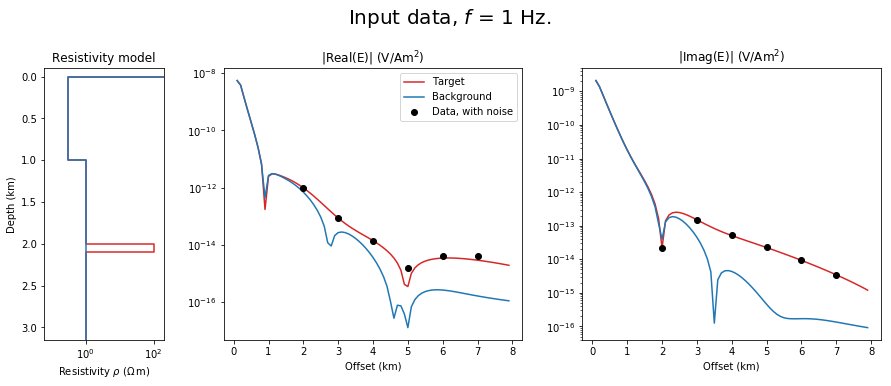

In [4]:
# Create arrays for resistivity model
pdepth = np.repeat(np.r_[-100, depth], 2)
pdepth[:-1] = pdepth[1:]
pdepth[-1] = 2*depth[-1]
pres = np.repeat(res, 2)
presBG = np.repeat(res[:-2], 2)

# Create figure
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=.5)
plt.suptitle('Input data, $f$ = '+str(freq)+' Hz.', y=1.05, fontsize=20)

# Plot Resistivities
plt.subplot(151)
plt.title('Resistivity model')
plt.plot(pres, pdepth/1000, 'C3', label='Target')
plt.plot(presBG, np.r_[pdepth[:-5], pdepth[-1]]/1000, 'C0', label='BG')
plt.xscale('log')
plt.xlim([.2*np.array(res).min(), 2*np.array(res)[1:].max()])
plt.ylim([1.5*depth[-1]/1000, -0.1])
plt.ylabel('Depth (km)')
plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')

# Plot Amplitude
plt.subplot2grid((1, 5), (0, 1), colspan=2)
plt.title(r'|Real(E)| (V/Am$^2$)')
plt.semilogy(xf/1000, np.abs(full.real), 'C3', label='Target')
plt.semilogy(xf/1000, np.abs(bg.real), 'C0', label='Background')
plt.semilogy(x/1000, np.abs(datan.real), 'ko', label='Data, with noise')
plt.legend(loc='best')
plt.xlabel('Offset (km)')

# Plot Phase
plt.subplot2grid((1, 5), (0, 3), colspan=2)
plt.title(r'|Imag(E)| (V/Am$^2$)')
plt.semilogy(xf/1000, np.abs(full.imag), 'C3', label='Target')
plt.semilogy(xf/1000, np.abs(bg.imag), 'C0', label='Background')
plt.semilogy(x/1000, np.abs(datan.imag), 'ko', label='Data, with noise')
plt.xlabel('Offset (km)')

plt.show()

## 2. Define inverse model

The main user-facing routines of `empymod` are `model.dipole` and `model.bipole`. However, they do a lot of stuff we want to avoid in an inversion scheme, such as input checks and timing.

In [5]:
# Define the inversion model: 20 layers, plus air, sea, and lower half-space
idepth = np.r_[-np.infty, 0, 1000+np.arange(21)*100]

# Initial resistivities (starting model resistivity)
sres = np.ones(idepth.shape)
sres[:2] = [2e14, 0.3]  # Air and water resistivity
ires = dc(sres)

# Calc zeta (isotropic)
zeta = np.ones((1, len(idepth)))*2j*np.pi*freq*mu_0

# Model parameters which we do not invert for (at the moment, at least)
fixed_params = {
    'zsrc': np.array(src[2]),
    'zrec': np.array(rec[2]),
    'lsrc': 1,
    'lrec': 1,
    'off': x,
    'angle': x*0,        # Angles (0, as we have y=0)
    'depth': idepth,
    'ab': 11,            # El., x-directed source and receivers
    'freq': np.array(freq),
    'zetaH': zeta,
    'zetaV': zeta,
    'msrc': False,       # Electric source
    'mrec': False,       # Electric receivers
}

# Stuff we don't touch at the moment and keep fixed
settings = {
    'isfullspace': False,
    'xdirect': False,                                 # Direct field in the wavenumber domain
    'ht': 'fht',                                      # FHT (digital linear filter)
    'htarg': (empymod.filters.key_201_2009(), None),  # Default FHT arguments
    'use_spline': True,                               # Lagged convolution
    'use_ne_eval': False,                             # Do not use `numexpr`
    'loop_freq': False,
    'loop_off': False,
    'conv': True
}

# Define a simple routine to calculate one forward model based only on resistivity
def calc_fm(res, fixed_params=fixed_params, settings=settings):

    # Calculate eta (isotropic)
    eta = np.atleast_2d(1/res + 2j*np.pi*freq*epsilon_0)

    # Calculate result
    out, _, _ = empymod.model.fem(etaH=eta, etaV=eta, **fixed_params, **settings)
    return np.squeeze(out)

# Get start model
startm = calc_fm(sres)

# Now we have the data in
print('Responses from the data:\n', data)

# The starting model in
print('\nResponses given the starting model:\n', startm)

# An the starting resistivities
print('\nStarting resistivities (without air, sea):\n', sres[2:])

Responses from the data:
 [ -9.74324192e-13 +2.18173650e-14j  -8.54722390e-14 +1.50122557e-13j
  -1.37799210e-14 +5.08498063e-14j   3.40877085e-16 +2.23590905e-14j
   3.37727772e-15 +9.28394571e-15j   2.84880274e-15 +3.44393442e-15j]

Responses given the starting model:
 [ -6.90136732e-13 +3.94120241e-14j   2.63521978e-14 +4.51625780e-14j
   3.55150865e-15 -4.34875921e-15j   1.11994973e-17 -4.57816883e-16j
   2.56483702e-16 -1.70138625e-16j   1.59236175e-16 -1.34966520e-16j]

Starting resistivities (without air, sea):
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.]


## 3. Inversion

I think this is now where `SimPEG` comes in. The inversion should now adjust `ires[2:]` (if we exclude air and sea layers) after given rules.

1. Calculate RMS
2. Calculate sensitivity
3. Adjust ires[2:] given certain rules
4. Re-calculate response

In [6]:
ires[11:14] = [25, 50, 25]  # "Manual inversion"
inv = calc_fm(ires)         # Re-calculate

## 4. Plot inversion result

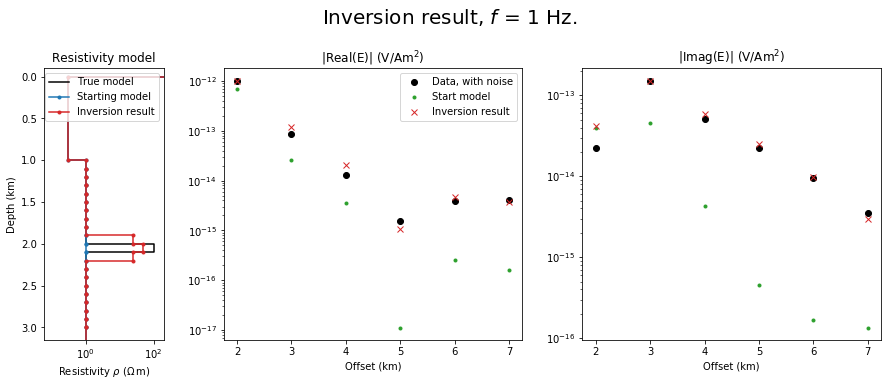

In [7]:
# Create arrays for resistivity model
ipdepth = np.repeat(idepth, 2)
ipdepth[:-1] = ipdepth[1:]
ipdepth[-1] = 2*idepth[-1]

spres = np.repeat(sres, 2)
ipres = np.repeat(ires, 2)

# Create figure
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=.5)
plt.suptitle('Inversion result, $f$ = '+str(freq)+' Hz.', y=1.05, fontsize=20)

# Plot Resistivities
plt.subplot(151)
plt.title('Resistivity model')
plt.plot(pres, pdepth/1000, 'k', label='True model')
plt.plot(spres, ipdepth/1000, 'C0.-', label='Starting model')
plt.plot(ipres, ipdepth/1000, 'C3.-', label='Inversion result')
plt.xscale('log')
plt.xlim([.2*np.array(res).min(), 2*np.array(res)[1:].max()])
plt.ylim([1.5*depth[-1]/1000, -0.1])
plt.legend()
plt.ylabel('Depth (km)')
plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')

# Plot Amplitude
plt.subplot2grid((1, 5), (0, 1), colspan=2)
plt.title(r'|Real(E)| (V/Am$^2$)')
plt.semilogy(x/1000, np.abs(datan.real), 'ko', label='Data, with noise')
plt.semilogy(x/1000, np.abs(startm.real), 'C2.', label='Start model')
plt.semilogy(x/1000, np.abs(inv.real), 'C3x', label='Inversion result')
plt.legend(loc='best')
plt.xlabel('Offset (km)')

# Plot Phase
plt.subplot2grid((1, 5), (0, 3), colspan=2)
plt.title(r'|Imag(E)| (V/Am$^2$)')
plt.semilogy(x/1000, np.abs(datan.imag), 'ko', label='Data, with noise')
plt.semilogy(x/1000, np.abs(startm.imag), 'C2.', label='Start model')
plt.semilogy(x/1000, np.abs(inv.imag), 'C3x', label='Inversion result')
plt.xlabel('Offset (km)')

plt.show()

In [8]:
import printinfo
printinfo.info()